# **🌾 Rice Leaf Disease Classification**

<img src="https://sinartani.co.id/wp-content/uploads/2023/11/20190112_142222-1024x536.jpg" width="500">

Klasifikasi penyakit pada daun padi menggunakan Deep Learning berbasis Convolutional Neural Network (CNN). Proyek ini bertujuan untuk membangun model machine learning yang mampu mengidentifikasi jenis penyakit dari gambar daun padi.

---

In [1]:
# Data Handling & Utilities
import os
import random
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Image Processing
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Building (MobileNetV2)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Model Training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report

# File Upload (Colab)
from google.colab import files

# Load Data
import urllib.request
import zipfile
import splitfolders

## **Data Preparation**

**Load Dataset**

In [2]:
data_url = 'https://github.com/wildanmujjahid29/Rice-Leaf-Disease-Classification/releases/download/v1.0/Original.Images.zip'
urllib.request.urlretrieve(data_url, 'Original.Images.zip')
local_file = 'Original.Images.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('data/')
zip_ref.close()

**Cek Distribusi Class**

In [3]:
base_dir = '/content/data/Original Images'
for class_name in os.listdir(base_dir):
  jumlah = len(os.listdir(os.path.join(base_dir, class_name)))
  print(f'{class_name} : {jumlah}')

Leaf scald : 189
Rice Hispa : 215
Bacterial Leaf Blight : 180
Sheath Blight : 271
Brown Spot : 267
Leaf Blast : 305
Healthy Rice Leaf : 157
Narrow Brown Leaf Spot : 117


**Sample Gambar Tiap Kelas**

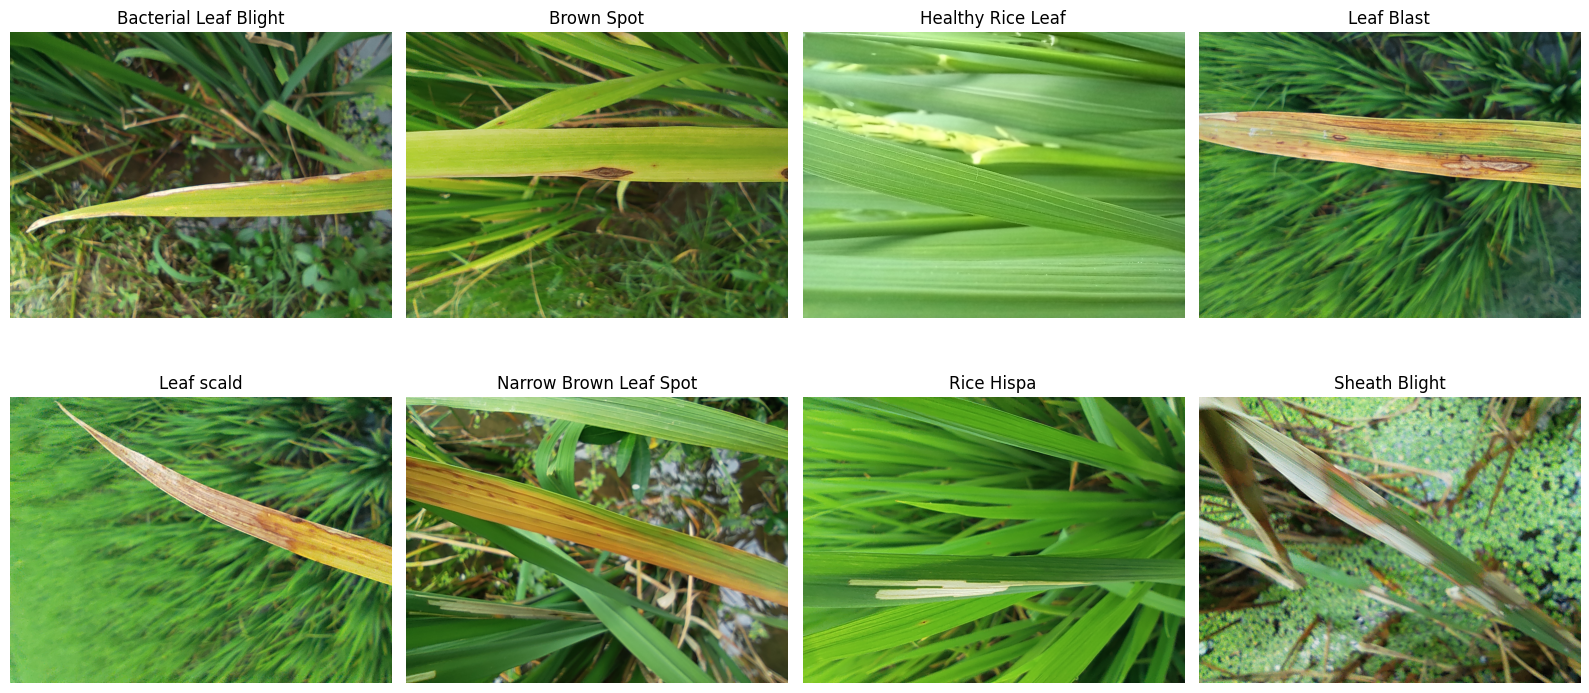

In [4]:
rows, cols = 2, 4
fig, axes = plt.subplots(rows, cols, figsize=(16, 8))

class_dirs = sorted(os.listdir(base_dir))  # Urutkan biar rapi

for i, class_name in enumerate(class_dirs):
    class_path = os.path.join(base_dir, class_name)
    image_file = os.listdir(class_path)[0]  # Ambil 1 gambar
    img_path = os.path.join(class_path, image_file)

    img = mpimg.imread(img_path)
    axes[i//cols, i%cols].imshow(img)
    axes[i//cols, i%cols].set_title(class_name)
    axes[i//cols, i%cols].axis('off')

plt.tight_layout()
plt.show()

**Split Data**

In [5]:
!pip install split-folders

In [6]:
splitfolders.ratio(base_dir, output="/content/split_data", seed=42, ratio=(.7, .2, .1))

Copying files: 1701 files [00:06, 267.37 files/s]


In [7]:
base_split_dir = '/content/split_data'
for split in ['train', 'val', 'test']:
    print(f'\n{split.upper()}')
    split_path = os.path.join(base_split_dir, split)
    for class_name in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_name)
        count = len(os.listdir(class_path))
        print(f'{class_name}: {count}')


TRAIN
Bacterial Leaf Blight: 125
Brown Spot: 186
Healthy Rice Leaf: 109
Leaf Blast: 213
Leaf scald: 132
Narrow Brown Leaf Spot: 81
Rice Hispa: 150
Sheath Blight: 189

VAL
Bacterial Leaf Blight: 36
Brown Spot: 53
Healthy Rice Leaf: 31
Leaf Blast: 61
Leaf scald: 37
Narrow Brown Leaf Spot: 23
Rice Hispa: 43
Sheath Blight: 54

TEST
Bacterial Leaf Blight: 19
Brown Spot: 28
Healthy Rice Leaf: 17
Leaf Blast: 31
Leaf scald: 20
Narrow Brown Leaf Spot: 13
Rice Hispa: 22
Sheath Blight: 28


**Augmentasi Gambar**

In [9]:
# Ukuran gambar target
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [10]:
train_dir = '/content/split_data/train'
val_dir = '/content/split_data/val'
test_dir = '/content/split_data/test'

# Untuk augmentasi hanya di train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1185 images belonging to 8 classes.
Found 338 images belonging to 8 classes.
Found 178 images belonging to 8 classes.


**Sample Gambar**

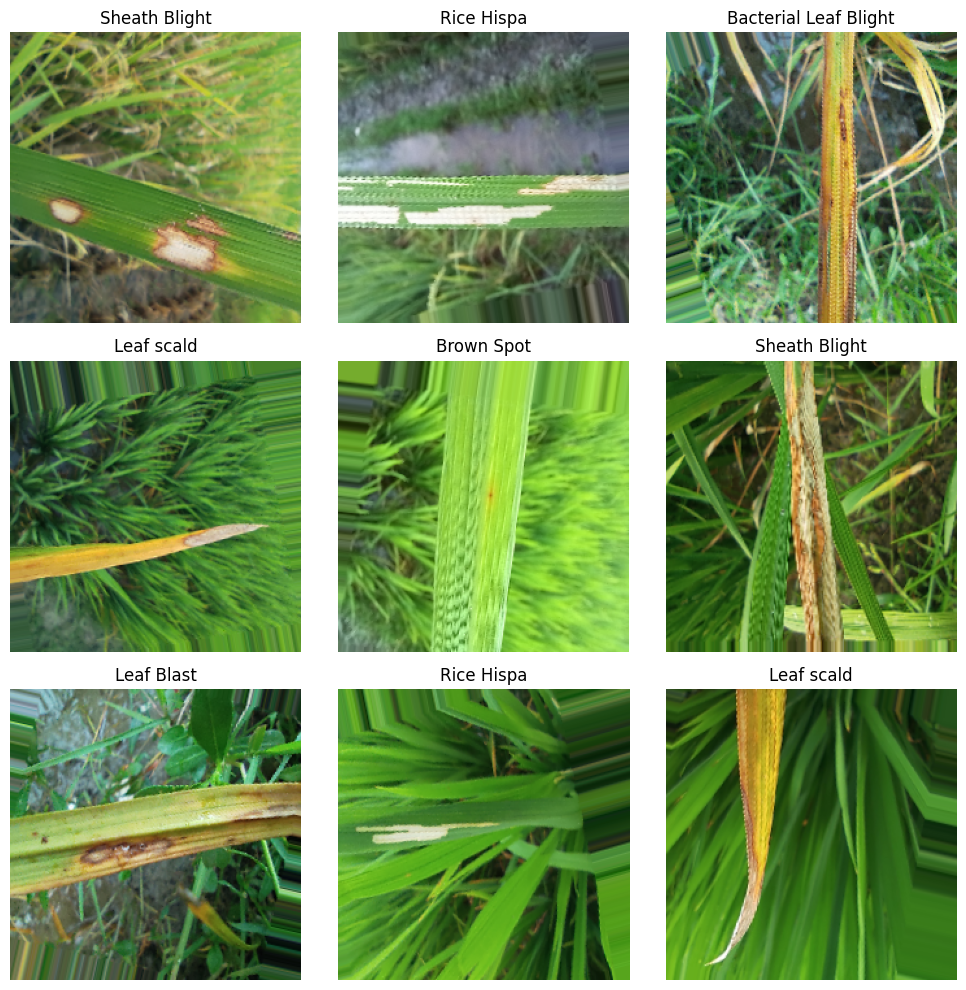

In [11]:
class_labels = list(train_gen.class_indices.keys())

# Ambil satu batch
images, labels = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_index = tf.argmax(labels[i]).numpy()
    plt.title(class_labels[label_index])
    plt.axis("off")
plt.tight_layout()
plt.show()

## **Model Development**

**MobileNetV2**

In [12]:
# Load base model MobileNetV2 tanpa top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze semua layer base
base_model.trainable = False

# Tambahkan custom classifier di atasnya
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,984 (9.24 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Compile Model**

In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Setup Callback**

In [14]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_mobilenetv2_model.h5', save_best_only=True)
]

**Training Model**

In [15]:
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2851 - loss: 2.0993

38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.2870 - loss: 2.0926 - val_accuracy: 0.5266 - val_loss: 1.3899
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.4876 - loss: 1.4231

38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4877 - loss: 1.4234 - val_accuracy: 0.5444 - val_loss: 1.2294
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - accuracy: 0.5413 - loss: 1.2924

38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5413 - loss: 1.2918 - val_accuracy: 0.5947 - val_loss: 1.1236
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.5896 - loss: 1.1100

38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5894 - loss: 1.1110 - val_accuracy: 0.6391 - val_loss: 1.0674
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.6486 - loss: 1.0305

38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6477 - loss: 1.0314 - val_accuracy: 0.6006 - val_loss: 1.0365
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.6291 - loss: 1.0998

38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6290 - loss: 1.0991 - val_accuracy: 0.6657 - val_loss: 0.9681
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.6263 - loss: 1.0453

38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6266 - loss: 1.0452 - val_accuracy: 0.6805 - val_loss: 0.9659
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.6495 - loss: 0.9605

38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6501 - loss: 0.9599 - val_accuracy: 0.6686 - val_loss: 0.9147
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6448 - loss: 0.9880 - val_accuracy: 0.6775 - val_loss: 0.9247
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.6879 - loss: 0.9263

38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6881 - loss: 0.9252 - val_accuracy: 0.6982 - val_loss: 0.8600
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7321 - loss: 0.7742 - val_accuracy: 0.6775 - val_loss: 0.9433
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.7275 - loss: 0.8026

38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7270 - loss: 0.8037 - val_accuracy: 0.7130 - val_loss: 0.8449
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7164 - loss: 0.7854 - val_accuracy: 0.6775 - val_loss: 0.8648
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7379 - loss: 0.7801 - val_accuracy: 0.6568 - val_loss: 0.8973
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.7029 - loss: 0.8271

38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7030 - loss: 0.8267 - val_accuracy: 0.7101 - val_loss: 0.8417
Epoch 16/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.7179 - loss: 0.7946

38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7180 - loss: 0.7939 - val_accuracy: 0.7189 - val_loss: 0.7845
Epoch 17/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7247 - loss: 0.7542 - val_accuracy: 0.7101 - val_loss: 0.8043
Epoch 18/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.7635 - loss: 0.6675

38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7631 - loss: 0.6696 - val_accuracy: 0.7160 - val_loss: 0.7705
Epoch 19/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7417 - loss: 0.7317 - val_accuracy: 0.7337 - val_loss: 0.7717
Epoch 20/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 0.7413 - loss: 0.7431

38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7413 - loss: 0.7427 - val_accuracy: 0.7426 - val_loss: 0.7590
Epoch 21/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7750 - loss: 0.6834 - val_accuracy: 0.7249 - val_loss: 0.7796
Epoch 22/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7473 - loss: 0.6861 - val_accuracy: 0.7130 - val_loss: 0.7882
Epoch 23/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7606 - loss: 0.6582 - val_accuracy: 0.7337 - val_loss: 0.7713
Epoch 24/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8037 - loss: 0.5861

38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8030 - loss: 0.5874 - val_accuracy: 0.7426 - val_loss: 0.7316
Epoch 25/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7806 - loss: 0.6322 - val_accuracy: 0.7041 - val_loss: 0.7983
Epoch 26/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7514 - loss: 0.6920 - val_accuracy: 0.7308 - val_loss: 0.7788
Epoch 27/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7528 - loss: 0.6606 - val_accuracy: 0.7278 - val_loss: 0.7450
Epoch 28/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7066 - loss: 0.7505 - val_accuracy: 0.7544 - val_loss: 0.7587
Epoch 29/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7920 - loss: 0.5993 - val_accuracy: 0.7160 - val_loss: 0.8074


In [16]:
loss, acc = model.evaluate(test_gen)
print(f"Test accuracy: {acc:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 776ms/step - accuracy: 0.7080 - loss: 0.7997
Test accuracy: 0.74


**Save Model**

In [18]:
model.save("rice_leaf_mobilenetv2.h5")

##  **Model Evaluation**

**Accuracy & Loss per Epoch**

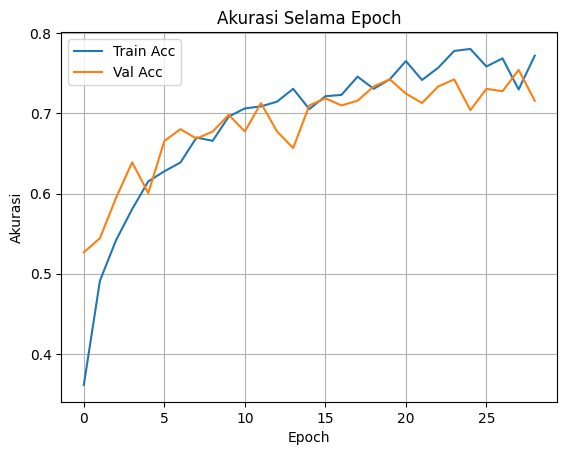

In [26]:
# Akurasi
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Akurasi Selama Epoch')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)
plt.show()

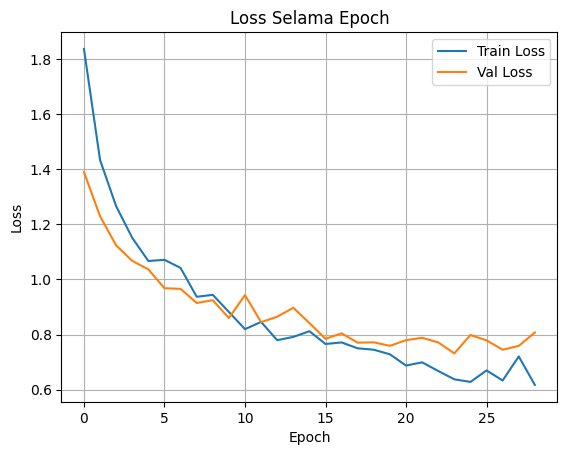

In [27]:
# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Selama Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Confusion Matrix**

In [46]:
class_names = os.listdir(test_dir)
class_names

['Leaf scald',
 'Rice Hispa',
 'Bacterial Leaf Blight',
 'Sheath Blight',
 'Brown Spot',
 'Leaf Blast',
 'Healthy Rice Leaf',
 'Narrow Brown Leaf Spot']

In [ ]:
# Ambil label asli dan prediksi

y_true = []
y_pred = []

for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    image_files = os.listdir(class_path)
    for image_name in image_files:
        image_path = os.path.join(class_path, image_name)

        img = image.load_img(image_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred = model.predict(img_array)
        pred_class_idx = np.argmax(pred[0])
        pred_class_name = list(train_gen.class_indices.keys())[pred_class_idx]

        y_true.append(class_name)
        y_pred.append(pred_class_name)

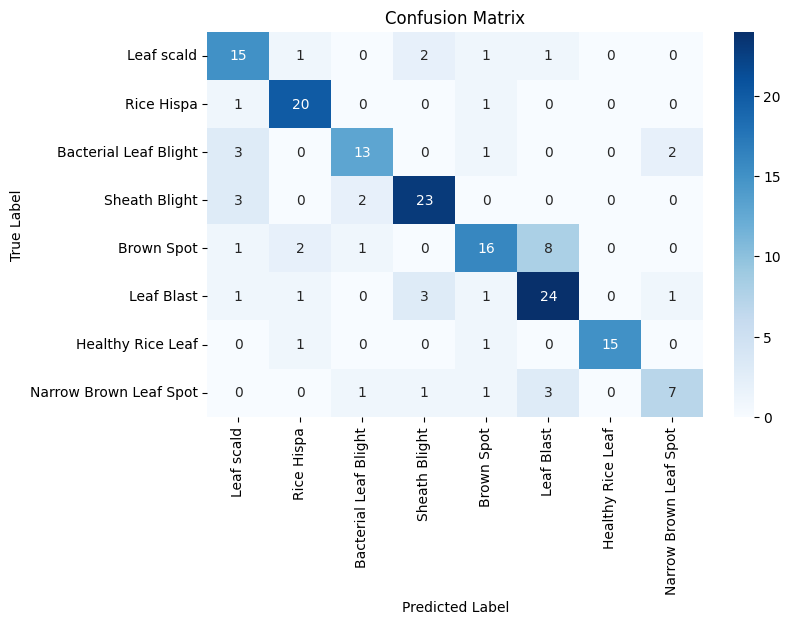

In [32]:
# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=class_names)

plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**classification report**

In [31]:
print(classification_report(y_true, y_pred))

                        precision    recall  f1-score   support

 Bacterial Leaf Blight       0.76      0.68      0.72        19
            Brown Spot       0.73      0.57      0.64        28
     Healthy Rice Leaf       1.00      0.88      0.94        17
            Leaf Blast       0.67      0.77      0.72        31
            Leaf scald       0.62      0.75      0.68        20
Narrow Brown Leaf Spot       0.70      0.54      0.61        13
            Rice Hispa       0.80      0.91      0.85        22
         Sheath Blight       0.79      0.82      0.81        28

              accuracy                           0.75       178
             macro avg       0.76      0.74      0.75       178
          weighted avg       0.75      0.75      0.75       178



## **Prediction Demo**

In [35]:
model = load_model('rice_leaf_mobilenetv2.h5')

In [36]:
train_gen.class_indices

{'Bacterial Leaf Blight': 0,
 'Brown Spot': 1,
 'Healthy Rice Leaf': 2,
 'Leaf Blast': 3,
 'Leaf scald': 4,
 'Narrow Brown Leaf Spot': 5,
 'Rice Hispa': 6,
 'Sheath Blight': 7}

In [37]:
def predict_rice_leaf(image_path):
    # Load & preprocess
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    pred = model.predict(img_array)
    class_idx = np.argmax(pred[0])
    predicted_label = class_labels[class_idx]

    # Tampilkan
    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_label}')

    plt.axis('off')
    plt.show()

    confidence = np.max(pred[0]) * 100
    print(f"Prediksi: {predicted_label} ({confidence:.2f}%)")

    return predicted_label

In [42]:
from google.colab import files
uploaded = files.upload()

Saving rice-sheath-blight-rice-1581427208.jpg to rice-sheath-blight-rice-1581427208.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


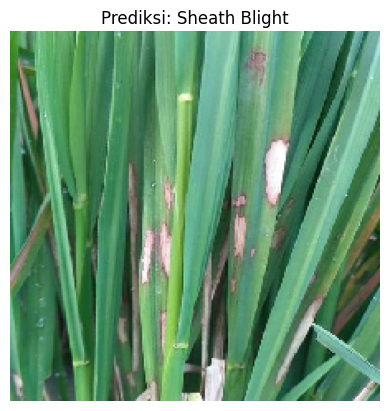

Prediksi: Sheath Blight (33.49%)


'Sheath Blight'

In [43]:
predict_rice_leaf('/content/rice-sheath-blight-rice-1581427208.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


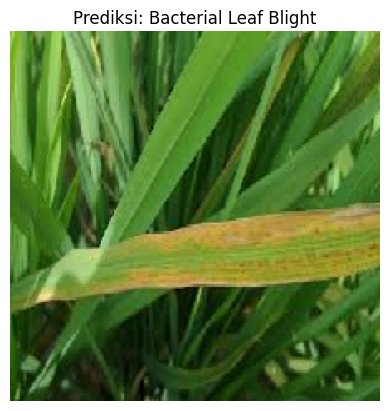

Prediksi: Bacterial Leaf Blight (38.90%)


'Bacterial Leaf Blight'

In [44]:
predict_rice_leaf('/content/images (3).jpg')